In [17]:
import numpy as np
from qiskit import IBMQ, Aer
import matplotlib.pyplot as plt
from main import device_process_measurement_tomography, Quantities, Cross_Quantities 
from qiskit.compiler import transpile 
from qiskit.providers.ibmq.managed import IBMQJobManager 
from qiskit.providers.aer.noise import NoiseModel 

Load your IBM account.

In [18]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

ibmqfactory.load_account:WARNING:2022-08-05 12:09:20,662: Credentials are already in use. The existing account in the session will be replaced.


Select your backend.

In [19]:
backend = provider.get_backend('ibmq_quito')
simulator = Aer.get_backend('aer_simulator')
noise_model = NoiseModel.from_backend(backend)

Initialize the class for the QND-measurement tomography of the backend. 

In [20]:
qndmt = device_process_measurement_tomography( backend )

Create the circuits.

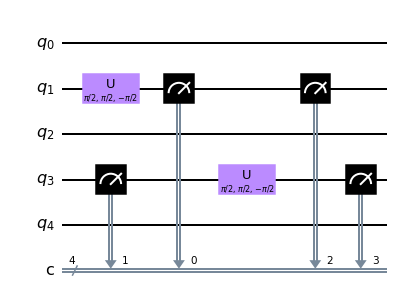

In [21]:
circuits_qndmt = qndmt.circuits()
circuits_qndmt[300].draw(output='mpl')

Run the circuits on the backend. We recommend using job_manager because the number of circuits needed for the tomography easily exceeds the maximum allowed by the backends. This splits the circuits in smaller groups and creates a set of jobs.

In [22]:
# job_manager = IBMQJobManager()
# job = job_manager.run( transpile( circuits_qndmt, backend ) , backend=backend, shots=2**13 )
# job.statuses() 

We also recommend saving the id the job. Using this id we can easily retrieve the experimental results.

In [23]:
# job_id = job.job_set_id()
# job_id 

This can be done with the following sentence.

In [24]:
# job = job_manager.retrieve_job_set( job_id, provider )

The results of the set of jobs can be combined into a single one.

In [25]:
# results = job.results().combine_results()

For simulations simply use the standard run function.

In [26]:
job = simulator.run( circuits_qndmt, noise_model=noise_model )
results = job.result()

We perform the post-processing of the experimental data to obtain the estimated Choi matrices. The argument "paralell=True" allows to use multicore for the post-processing, while "gate_set=True" mitigate the initialization and gate errors with gate set tomography. 

In [27]:
choi_single, choi_double, gateset  = qndmt.fit( results, paralell=True, gate_set=True ) 

The QND-MT class save information about de the device, such as the number of qubit and the groups of the parallelization.

In [28]:
num_qubits    = qndmt._num_qubits
parall_qubits = qndmt._parall_qubits

print( num_qubits )
print( parall_qubits )

5
[[(1, 3)], [(0, 1), (3, 4)], [(1, 2)]]


The estimated choi matrices can be used for compute the readout fidelity, qndness, destructiviness, and the cross-quantities. 

In [29]:
quantities = []
for k in range(num_qubits):
    quantities.append( Quantities( choi_single[k][0], choi_single[k][1] ) )

quantities_2 = []
cros_quantities = []
for i in range(len(parall_qubits)):
    for j in range(len(parall_qubits[i])):
        k = parall_qubits[i][j][0]
        l = parall_qubits[i][j][1]
        cros_quantities.append( Cross_Quantities( choi_single[k][0], choi_single[k][1],
                                                  choi_single[l][0], choi_single[l][1],
                                                  choi_double[i][j][0], choi_double[i][j][1]
                                                )  )
        quantities_2.append( Quantities( choi_double[i][j][0], choi_double[i][j][1] ) )

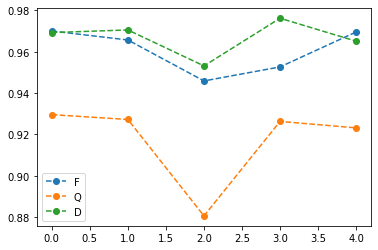

In [30]:
plt.plot( quantities, '--o' )
plt.legend( ['F','Q', 'D'] )

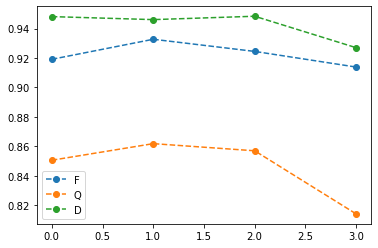

In [31]:
plt.plot( quantities_2, '--o' )
plt.legend( ['F','Q', 'D'] )

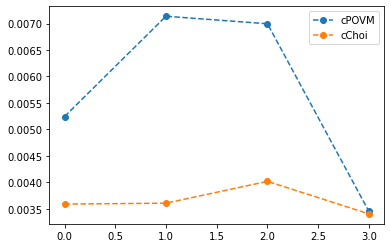

In [32]:
plt.plot( np.array(cros_quantities), '--o' )
plt.legend( ['cPOVM','cChoi'] )